# Transfer
This notebook will transfer a pre-fitted HBR model to a small dataset. 

In [ ]:
!pip install git+https://github.com/amarquand/PCNtoolkit.git@v1.alpha.5
!pip install numpy==1.26.4

In [1]:
import os
from pcntoolkit import (
    load_fcon1000,
    NormativeModel,
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from pcntoolkit.util.output import Output
from modelspec import shashb1

Output.set_show_messages(False)

## Why do we transfer?
First we will demonstrate why we need transfer in the first place. 

Let's say we want to make a normative model, and we only have access to a small dataset:

In [2]:
# Download the dataset and select these two sites
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, _ = load_fcon1000(save_path="../data").split_batch_effects(
    {"site": transfer_sites}, names=("transfer", "fit")
)
# Select only a few features
features_to_model = [
    "WM-hypointensities",
    "Right-Lateral-Ventricle",
    "Right-Amygdala",
    "CortexVol",
]
transfer_data = transfer_data.sel({"response_vars": features_to_model})
print(
    f"This dataset contains {len(transfer_data.observations)} samples of {len(transfer_data.response_vars)} response variables"
)

transfer_train, transfer_test = transfer_data.train_test_split()


This dataset contains 148 samples of 4 response variables


### Inspecting the data
As we see in the plot below, our available data does cover the entire age range, but rather is concentrated in the ages between 20 and 22, and between ages 44 and 67. If we fit a model on this data, the predictions between 22 and 44 that it makes will be a 'best guess' between those clusters.

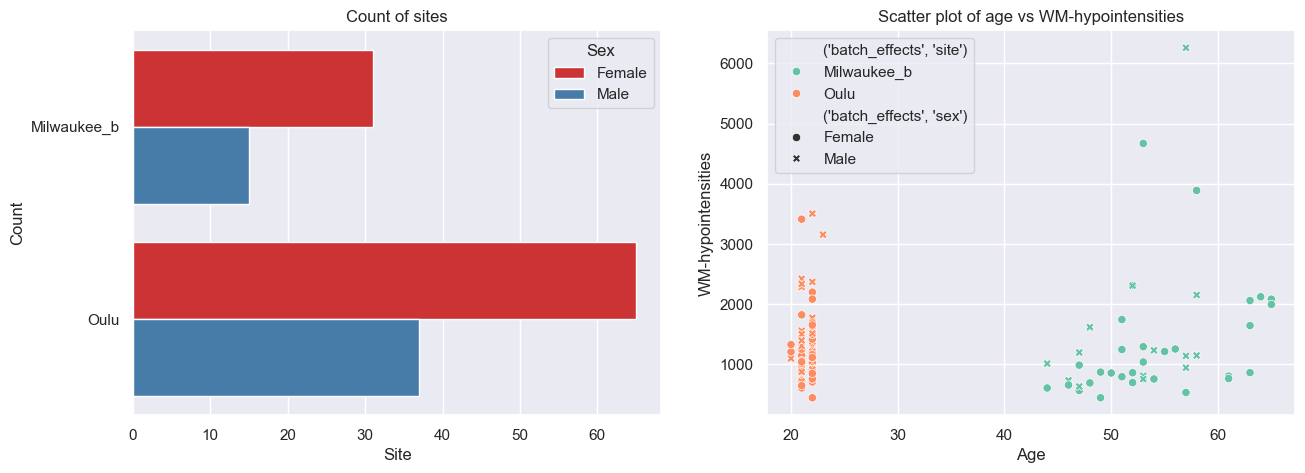

In [3]:
# Inspect the data
feature_to_plot = features_to_model[0]
df = transfer_data.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(
    data=df,
    y=("batch_effects", "site"),
    hue=("batch_effects", "sex"),
    ax=ax[0],
    orient="h",
    palette="Set1",
)
ax[0].legend(title="Sex")
ax[0].set_title("Count of sites")
ax[0].set_xlabel("Site")
ax[0].set_ylabel("Count")


sns.scatterplot(
    data=df,
    x=("X", "age"),
    y=("Y", feature_to_plot),
    hue=("batch_effects", "site"),
    style=("batch_effects", "sex"),
    ax=ax[1],
    palette="Set2",
)
# ax[1].legend([], [])
ax[1].set_title(f"Scatter plot of age vs {feature_to_plot}")
ax[1].set_xlabel("Age")
ax[1].set_ylabel(feature_to_plot)

plt.show()

### Fitting a model to the small dataset
Let's fit a model to this dataset.

In [4]:
new_model = shashb1
new_model.set_save_dir("../models/new_model")
test = new_model.fit_predict(transfer_train, transfer_test)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.01,1023
,2000,0,0.01,1023
,2000,0,0.01,1023
,2000,0,0.01,1023


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.01,1023
,2000,0,0.01,1023
,2000,0,0.01,1023
,2000,0,0.01,1023


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.01,1023
,2000,0,0.01,1023
,2000,0,0.01,1023
,2000,0,0.01,1023


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.01,1023
,2000,0,0.01,1023
,2000,0,0.01,1023
,2000,0,0.01,1023


Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
/opt/anaconda3/envs/federated_learning_workshop/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

### Inspecting the model output
Now go to the `models/new_model/plots` directory, and open some centiles plots. They do not follow a natural curve, especially in the range between 22 and 44. We already expected this, so it's nice to see it confirmed.


## Transfering a pre-fitted model to our small dataset

Now we will do it the right way. 

We will take a model that was previously fitted on a larger dataset - N.B.: on different sites - and transfer it to our small dataset. By transfering, we take the original model as a starting point, and adapt it slightly to our new dataset. This will ensure that a lot of the model characteristics are retained, so also the predictions in the age range 22-44.

In [5]:
# Load the normative model
model_to_transfer = NormativeModel.load("../models/model_to_transfer")
# Show the batch effects that this model was fitted on:
print("This model was trained on these batches:")
model_to_transfer.unique_batch_effects

This model was trained on these batches:


{'sex': ['Female', 'Male'],
 'site': ['AnnArbor_a',
  'AnnArbor_b',
  'Atlanta',
  'Baltimore',
  'Bangor',
  'Beijing_Zang',
  'Berlin_Margulies',
  'Cambridge_Buckner',
  'Cleveland',
  'ICBM',
  'Leiden_2180',
  'Leiden_2200',
  'Munchen',
  'NewYork_a',
  'NewYork_a_ADHD',
  'Newark',
  'Oxford',
  'PaloAlto',
  'Pittsburgh',
  'Queensland',
  'SaintLouis']}

In [6]:
# Sanity check: try to use the pre-fitted model to predict on the transfer data.
# This throws an error, because our transfer data only contains data from "Milwaukee_b" and "Oulu", which were not in the original training set (see list directly above this cell)
try:
    model_to_transfer.predict(transfer_test)
except Exception as e:
    print(f"This should throw an error!: {e}")

This should throw an error!: Data is not compatible with the model!


/opt/anaconda3/envs/federated_learning_workshop/lib/python3.12/site-packages/pcntoolkit/util/output.py:207: UserWarning: Process: 61237 - 2025-05-20 11:29:40 - The dataset transfer_test has unknown batch effects: {'sex': [], 'site': ['Milwaukee_b', 'Oulu']}
  warnings.warn(message)


In [7]:
# Now we transfer the model:
transfered_model = model_to_transfer.transfer_predict(
    transfer_train, transfer_test, save_dir="../models/transferred_model"
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.04,127
,2000,0,0.03,255
,2000,0,0.03,255
,2000,0,0.05,255


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.03,127
,2000,0,0.04,255
,2000,0,0.03,255
,2000,0,0.02,255


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.02,511
,2000,0,0.03,255
,2000,0,0.04,255
,2000,0,0.04,127


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.03,255
,2000,0,0.03,511
,2000,0,0.03,255
,2000,0,0.03,255


Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
/opt/anaconda3/envs/federated_learning_workshop/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

## Inspect the model output

Let's compare the centiles from the new model and the centiles from the transfered model side by side

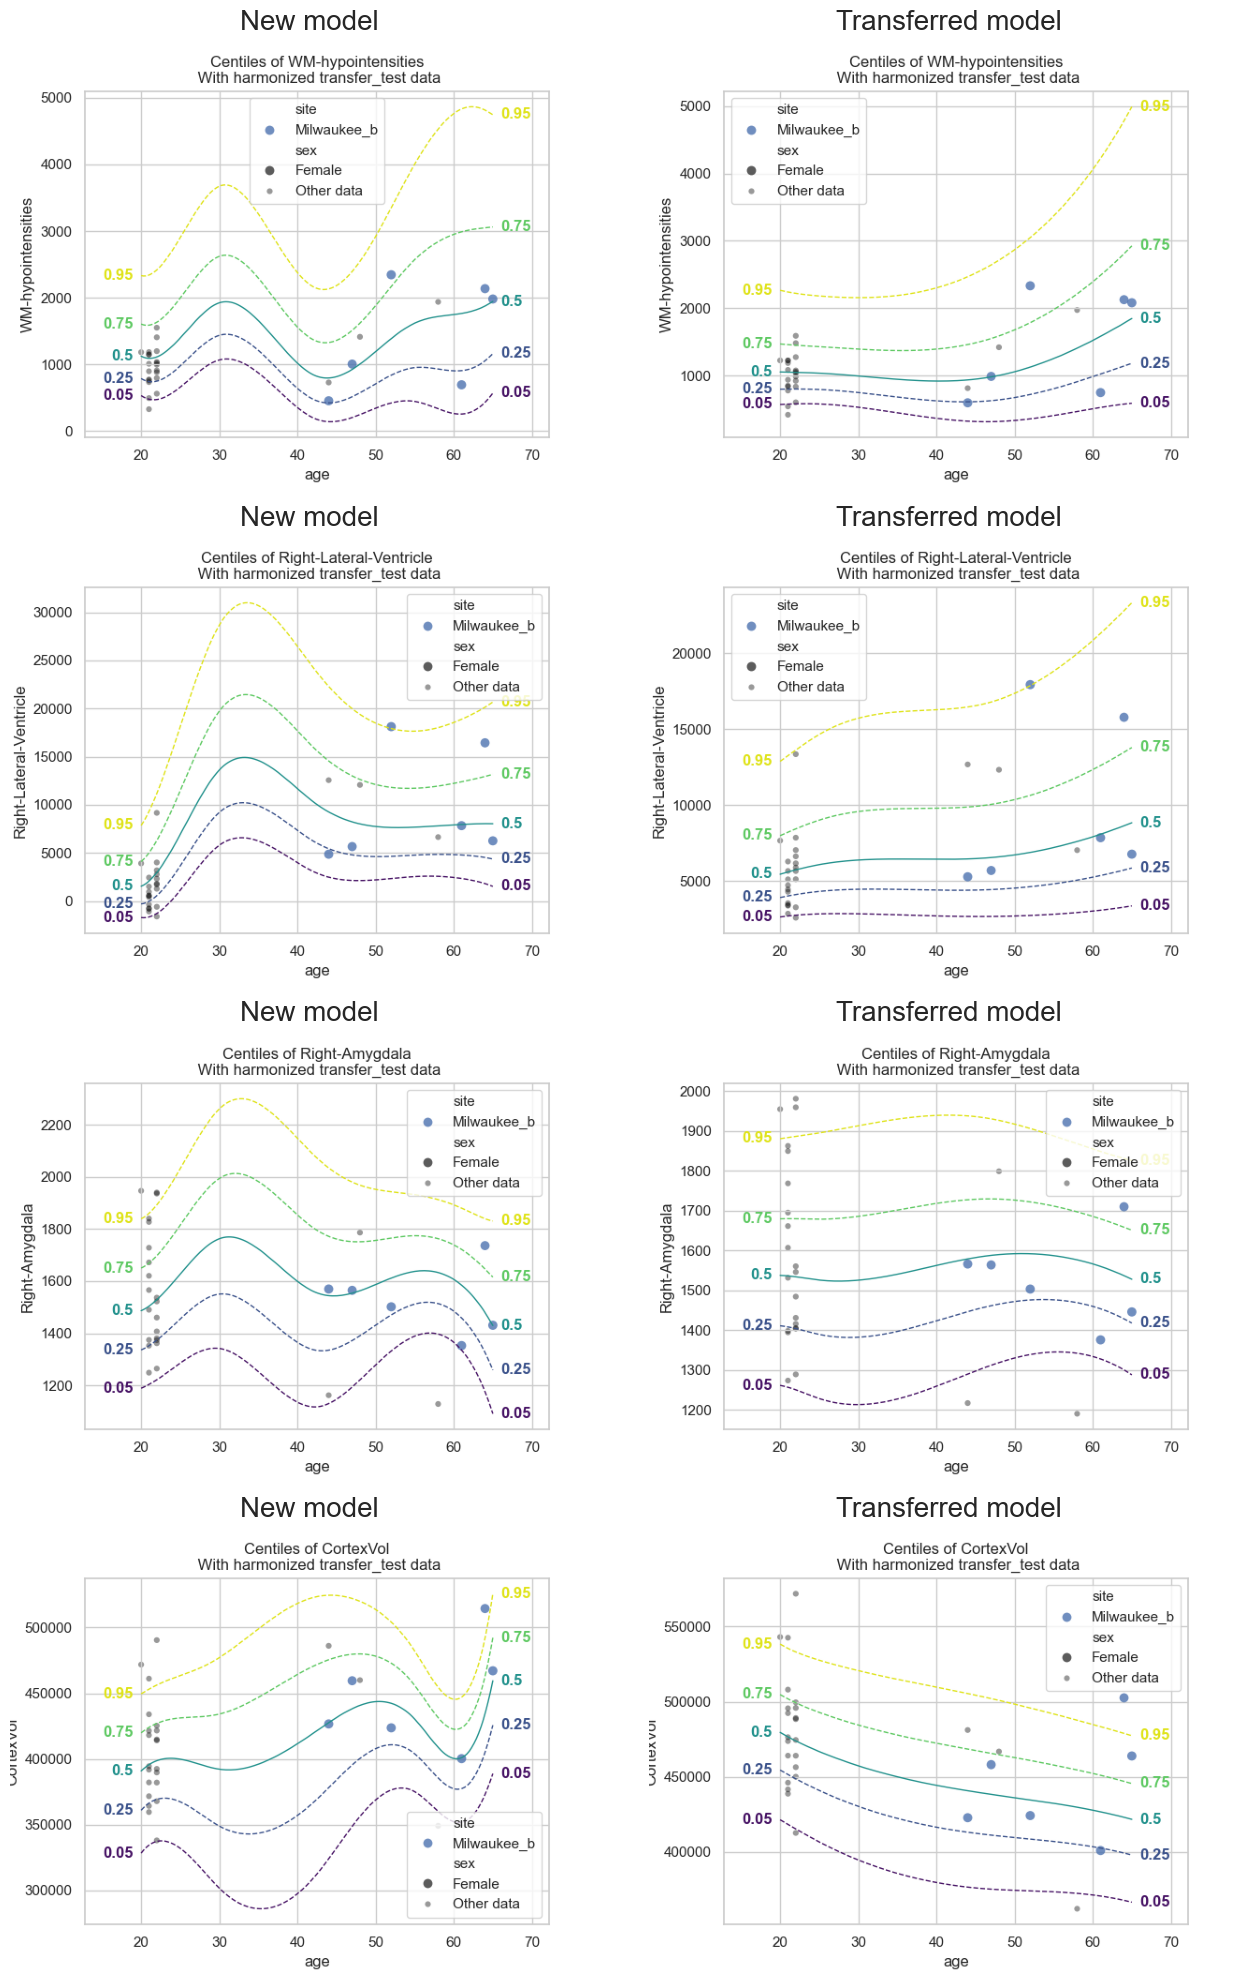

In [8]:
fig, ax = plt.subplots(len(features_to_model), 2, figsize=(13, 20))
for i, f in enumerate(features_to_model):
    centile_plot_transferred_model = np.asarray(
        Image.open(
            f"../models/transferred_model/plots/centiles_{f}_transfer_test_harmonized.png"
        )
    )
    centile_plot_new_model = np.asarray(
        Image.open(
            f"../models/new_model/plots/centiles_{f}_transfer_test_harmonized.png"
        )
    )

    plt.axis("off")
    plt.rcParams["axes.titlesize"] = 20

    ax[i, 0].imshow(centile_plot_new_model)
    ax[i, 0].axis("off")
    ax[i, 0].set_title("New model")

    ax[i, 1].imshow(centile_plot_transferred_model)
    ax[i, 1].axis("off")
    ax[i, 1].set_title("Transferred model")
    plt.tight_layout()
